# Introduction to classification

<img src="https://www.mrtfuelcell.polimi.it/images/logo_poli.jpg" height="200">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg" height="150">

A2A ML Course - day 5 - xx/10/2024

Maciej Sakwa, Micheal Wood, Emanuele Ogliari

## Outline

1. Machine Learning Project Structure (review)
2. Logistic Regression
3. Evaluation metrics in classification
4. Case study (EV data + multiclass classification)

## Learning obejctives

* Understand the logistic function and its use in classification problems
* Define typical metrics used to describe classification problems (accuracy, precision, recall)
* Understand the differences in approach between binary and multiple choice problems



**Please run the cells below with imports and function declarations** 

Feel free to skip the details of the content.

---

Imports:

In [296]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format # print 2 decimal places
pd.options.mode.chained_assignment = None

Data preprocessing functions:

In [253]:
def import_data(filepath):
    df = pd.read_csv(filepath,index_col='time',)
    df.index = pd.to_datetime(df.index,utc=True,format='ISO8601')
    df.index = df.index.tz_convert('Europe/Madrid').tz_localize(None)
    return df

def preprocess_data(data):

    zeros_list = [
        'generation fossil coal-derived gas',
        'generation fossil oil shale',
        'generation fossil peat',
        'generation geothermal',
        'generation marine',
        'generation wind offshore',
        'generation hydro pumped storage aggregated',
        'forecast wind offshore eday ahead']
    nonzeros_list = [x for x in data.columns if x not in zeros_list]

    generations_list = [x for x in nonzeros_list if x.startswith('generation')]

    data = data[generations_list]

    return data.ffill()

Maths functions:

In [254]:
def logit(x):
    return 1 / (1 + np.exp(-x))

def log_loss(labels, probas):
    
    log_probas = np.log([probas[i] if labels[i] == 1 else (1-probas[i]) for i in range(len(probas))])
    loss = sum(log_probas)

    return np.mean(-loss)

Plotting functions:

In [255]:
def plot_scatter(data, x_col='generation fossil hard coal', y_col='generation wind onshore', w=None, b=None, GoF=False):

    groups = data.groupby('label')
    for name, group in groups: 
        plt.scatter(x=group[x_col], y=group[y_col], label=f'Label: {name}')
    plt.xlabel('Generation Coal (GW) - x')
    plt.ylabel('Generation Wind (GW) - y')

    if w is not None:
        x = np.linspace(1000, 5000, 100)
        y = w * x + b
        plt.plot(x, y, linestyle='--', c='r', label='Division boundary')

    if GoF:
        est = (data[y_col] - (w * data[x_col] + b)) / data[y_col].std()
        probas = logit(est)
        loss = log_loss(data['label'], probas)
        plt.title(f'Log loss: {loss:.2f}')

    plt.legend()
    plt.show()

def plot_logit(data=None, x_col=None, y_col=None, threshold=None, mark_classes=False, **kwargs): # you don't have to understand this code

    x = np.linspace(-6, 6, 1000)
    colors = ['teal', 'orange']

    plt.figure(**kwargs)
    plt.axhline(0, c='k', linestyle = ':', alpha = 0.5, linewidth=1)
    plt.axhline(1, c='k', linestyle = ':', alpha = 0.5, linewidth=1)
    plt.axvline(0, c='k', linewidth=1, alpha = 0.5)
    plt.plot(x, logit(x), c = 'grey')
    plt.title('Logistic function')
    plt.xlabel('Estimate value')
    plt.ylabel('Logit value')

    if data is not None:
        if mark_classes:
            groups = data.groupby('label')
            for i, group in enumerate(groups):
                name, df = group
                plt.scatter(df[x_col], df[y_col], label = f'Class: {name}', c=colors[i], zorder=3, alpha=0.5)
        else:
            plt.scatter(data[x_col], data[y_col], c='r', zorder=3)

    if threshold is not None:
        data['pred'] = [1 if x >= threshold else 0 for x in data[y_col]]
        groups = data.groupby('pred')
        for i, group in enumerate(groups):
            name, df = group
            plt.scatter(df[x_col], df['pred'], c=colors[i], zorder=3, marker='x', label=f'Pred Class: {name}')
            for i, row in df.iterrows():
                x = row[x_col]
                y_1, y_2 = (row[y_col], row['pred'])
                plt.plot([x, x], [y_1, y_2], c='grey', linewidth=0.5, linestyle='--')
        plt.axhline(threshold, c='red', linestyle='--', linewidth=1, label='Threshold')
        plt.legend()

**Did you run all the cells?**

---

## Machine Learning Project Structure

Import data - it's the same dataset as before. Now we will focus a bit more on the different generations.

In [256]:
data = import_data('https://raw.githubusercontent.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/refs/heads/main/data/energy_supply.csv')
data = preprocess_data(data)
data.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore
time,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.00,329.00,4844.00,4821.00,162.00,863.00,1051.00,1899.00,7096.00,43.00,73.00,49.00,196.00,6378.00
2015-01-01 01:00:00,449.00,328.00,5196.00,4755.00,158.00,920.00,1009.00,1658.00,7096.00,43.00,71.00,50.00,195.00,5890.00
2015-01-01 02:00:00,448.00,323.00,4857.00,4581.00,157.00,1164.00,973.00,1371.00,7099.00,43.00,73.00,50.00,196.00,5461.00
2015-01-01 03:00:00,438.00,254.00,4314.00,4131.00,160.00,1503.00,949.00,779.00,7098.00,43.00,75.00,50.00,191.00,5238.00
2015-01-01 04:00:00,428.00,187.00,4130.00,3840.00,156.00,1826.00,953.00,720.00,7097.00,43.00,74.00,42.00,189.00,4935.00


Our data does not have a categorical label. Let's cheat a bit and add our own label

It is based on the share of renewables production in a given hour 

1 if the share is above 50%, 0 if it's below 50%

In [257]:
renewables_list = [
    'generation other renewable',
    'generation solar', 
    'generation hydro water reservoir', 
    'generation hydro run-of-river and poundage', 
    'generation biomass',
    'generation wind onshore',
    'generation hydro pumped storage consumption',
    ]

data['renewables share'] = data[renewables_list].sum(axis=1)  / data.sum(axis=1)
data['label'] = [1 if i >= 0.5 else 0 for i in data['renewables share']]

Plot the label and share:

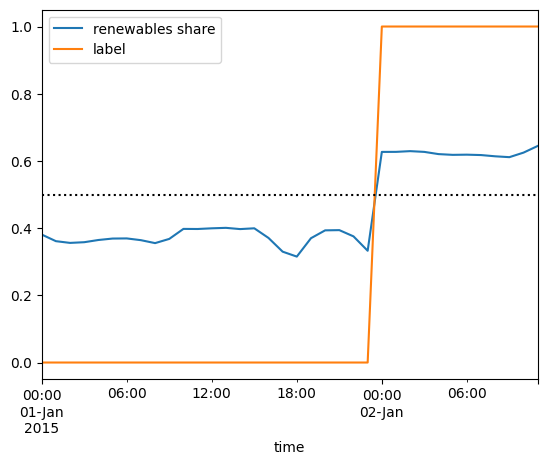

In [258]:
data[['renewables share','label']][:36].plot()
plt.axhline(0.5, c='k', linestyle=':', label='cutoff');

In [259]:
data.label.value_counts()

label
0    27311
1     7753
Name: count, dtype: int64

**PROBLEM DEFINITION:** Detect the class (renewable majority or minority in share) based on variables form the dataset. 

|I/O|  Data |
| --- | --- |
|Inputs| `generation fossil coal hard`, `generation wind onshore`, etc |
|Target|  `label` |
|Output| `label estimate` |

Let's try approaching the topic as we did before:

Import libraries:

In [260]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler 

Split inputs and labels:

In [261]:
input_columns = data.columns.to_list() 
input_columns.remove('label')

In [262]:
inputs = data[input_columns].copy()
labels = data[['label']].copy()

Scale inputs:

In [263]:
scaler = MinMaxScaler() 

In [264]:
inputs_scaled = scaler.fit_transform(inputs) 
labels_scaled = labels.values.ravel()

Divide in train and test dataset:

In [265]:
n = len(inputs) 
cutoff = int(0.7*n) # Train on 70% of the data, test on 30%

train_inputs = inputs_scaled[:cutoff]   # Cut before
train_labels = labels_scaled[:cutoff]   # Cut before

test_inputs = inputs_scaled[cutoff:]    # Cut after
test_labels = labels_scaled[cutoff:]    # Cut after

Declare and fit the linear model:

In [266]:
model = LinearRegression()
model.fit(X=train_inputs, y=train_labels)

LinearRegression()

Show results:

In [267]:
results = model.predict(test_inputs)

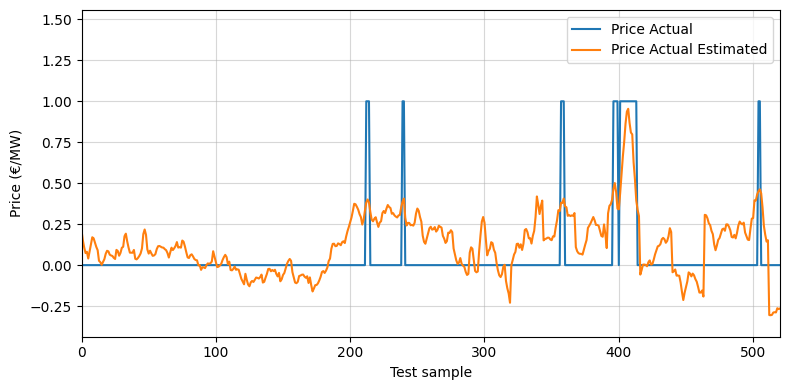

In [268]:
plt.figure(figsize=(8, 4))

# Plots
plt.plot(test_labels, label='Price Actual')
plt.plot(results, label='Price Actual Estimated')

# Visuals
plt.xlim((0,520))
plt.xlabel('Test sample')
plt.ylabel('Price (€/MW)')
plt.grid(which='major', alpha = 0.5)

# Tidy up
plt.legend()
plt.tight_layout()
plt.show()

It's garbage! 

In this case we are going to skip the evaluation of the results, as it is obvious we are not going to do right.

Besides, for classification we will have to define new metrics that better fit the task.

## Logistic regression

As we are not predicting an exact value a traditional linear regression is useless.

We have to create a function that outputs values between 0 and 1.

### Logistic regression - "by hand" 

In standard linear regression our output was defined with an equation $ w \cdot X + b = \hat{y} $.

Let's consider a 2D case with 2 columns of data for now:

In [269]:
X = data[['generation fossil hard coal', 'generation wind onshore', 'label']][0:120]

We can visualise it on a scatter plot:

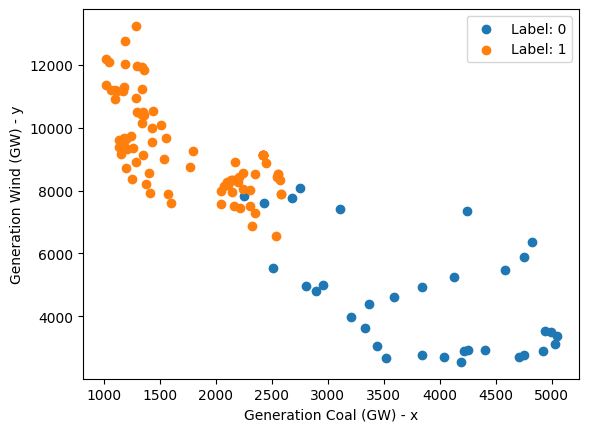

In [270]:
plot_scatter(X)

The instances are collored according to the label that we defeined before, orange means high renewable share, blue the opposite.

What is interesting is that we can easily *see* the division between the groups.

In fact, let's try to draw a line between the groups:

In [271]:
w = 3
b = 1000

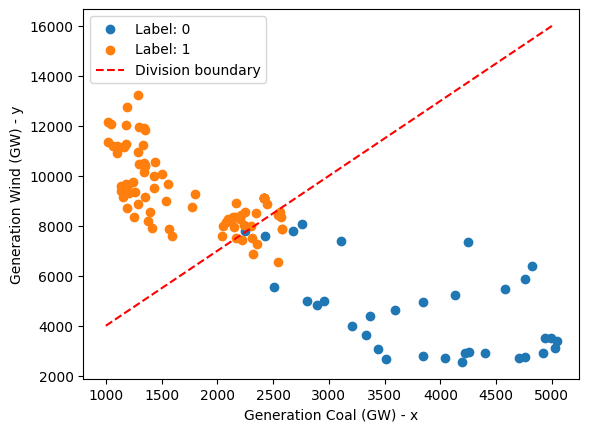

In [272]:
plot_scatter(X, w=w, b=b)

We can "estimate" the class by deciding if the point is above or below our line. If it's above it's positive, otherwise negative.

We can do it by simply substracting the line y-value from the point y-value.

In [273]:
X['estimate'] = (X['generation wind onshore'] - (w * X['generation fossil hard coal'] + b))     # Subtract the line value
X['estimate'] = X['estimate'] / (X['generation wind onshore'].std())                            # Standardize by dividing by the standard deviation of y (just for better scale)
X.head()

,generation fossil hard coal,generation wind onshore,label,estimate
time,,,,
2015-01-01 00:00:00,4821.00,6378.00,0,-3.42
2015-01-01 01:00:00,4755.00,5890.00,0,-3.53
2015-01-01 02:00:00,4581.00,5461.00,0,-3.49
2015-01-01 03:00:00,4131.00,5238.00,0,-3.07
2015-01-01 04:00:00,3840.00,4935.00,0,-2.85


We ended up with a bunch of positive and negative values specified for the points in our dataset. We have to convert them somehow into classes.

So what we really have to do is to impose a function $\sigma$ on our results, that flattens it at the ends to 0 and 1.

$$ \sigma(\hat{y}) = \sigma(w \cdot X + b) $$

where $\sigma$ is our flattening function.

The answer to that is the **logistic function** (also called a **log**istic un**it** or **logit** for short):

$$
\sigma(\hat{y}) = \frac{1}{1 - \exp(-(w \cdot X + b))}
$$

To plot the logit function run the cells below:

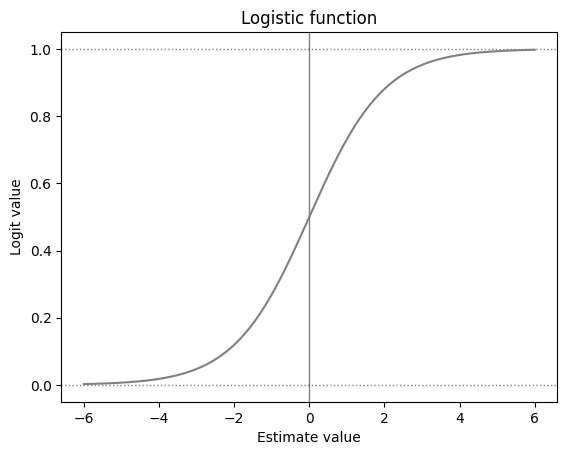

In [274]:
plot_logit()

You may remember it from the previous lesson :)

Let's apply it to our estimate:

In [275]:
X['logit estimate'] = logit(X['estimate'])
X.head()

,generation fossil hard coal,generation wind onshore,label,estimate,logit estimate
time,,,,,
2015-01-01 00:00:00,4821.00,6378.00,0,-3.42,0.03
2015-01-01 01:00:00,4755.00,5890.00,0,-3.53,0.03
2015-01-01 02:00:00,4581.00,5461.00,0,-3.49,0.03
2015-01-01 03:00:00,4131.00,5238.00,0,-3.07,0.04
2015-01-01 04:00:00,3840.00,4935.00,0,-2.85,0.05


Let's plot the points:

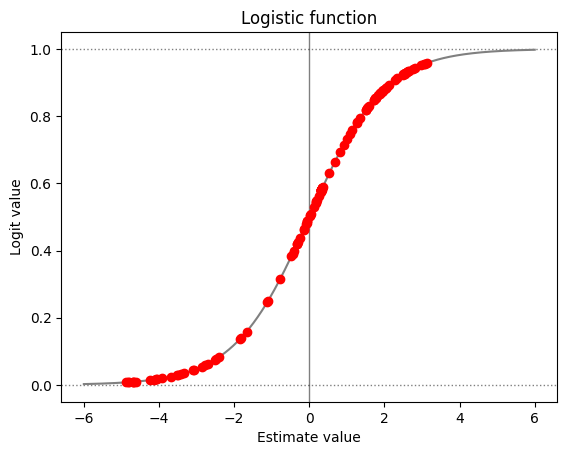

In [276]:
plot_logit(X, x_col='estimate', y_col='logit estimate') # Put mark_classes = True to see the true class of each point

The output of the logistic function is not really the binary 0-1 label. It is a value in the 0-1 range.

We say that the output of a logistic function is the estimated **probability** that an inputs belongs to the 1 class.

$
    \hat{p} = \sigma(\hat{y}) 
$

In [277]:
X.head()

,generation fossil hard coal,generation wind onshore,label,estimate,logit estimate
time,,,,,
2015-01-01 00:00:00,4821.00,6378.00,0,-3.42,0.03
2015-01-01 01:00:00,4755.00,5890.00,0,-3.53,0.03
2015-01-01 02:00:00,4581.00,5461.00,0,-3.49,0.03
2015-01-01 03:00:00,4131.00,5238.00,0,-3.07,0.04
2015-01-01 04:00:00,3840.00,4935.00,0,-2.85,0.05


For example, the first point at 2015-01-01 00:00:00 has a **12% probability** of being the member of **class 1**.

So probably, it is not the member of **class 1**. But what if it was **60%**? Does it belong to **class 1** or not?

What % is the cutoff?

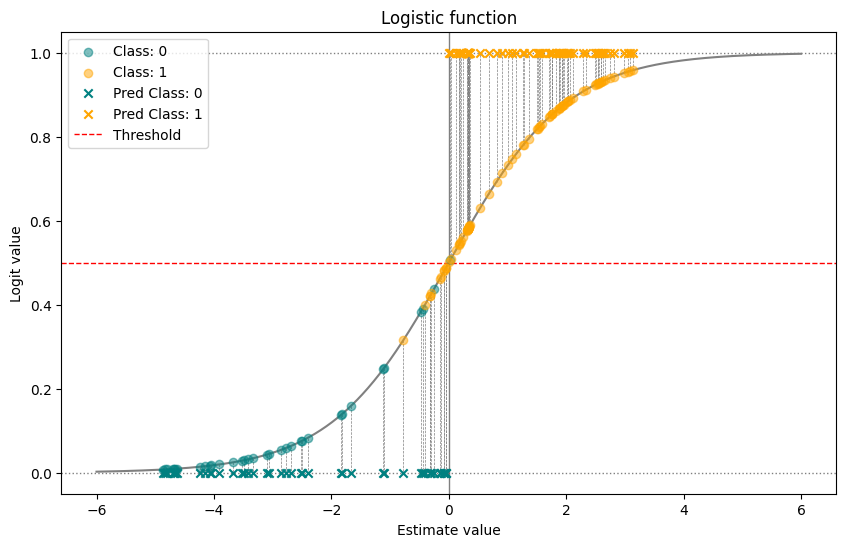

In [279]:
selected_threshold = 0.5  # Try to change the threshold a bit to see how it changes

# PLot the logit
plot_logit(X, x_col='estimate', y_col='logit estimate', mark_classes=True, threshold=selected_threshold, figsize=(10, 6))

In [227]:
X['pred'] = [1 if est >= selected_threshold else 0 for est in X['logit estimate']]
X.head()

,generation fossil hard coal,generation wind onshore,label,estimate,logit estimate,pred
time,,,,,,
2015-01-01 00:00:00,4821.00,6378.00,0,-3.42,0.03,0
2015-01-01 01:00:00,4755.00,5890.00,0,-3.53,0.03,0
2015-01-01 02:00:00,4581.00,5461.00,0,-3.49,0.03,0
2015-01-01 03:00:00,4131.00,5238.00,0,-3.07,0.04,0
2015-01-01 04:00:00,3840.00,4935.00,0,-2.85,0.05,0


**And there we go!** The instances are divided into separate binary classes. 

### Goodness of fit

Now, we have to specify the *goodness of fit* metric for the algorithm to minimize (similarly to the squares in regression). In case of classification it is called the **Log-Loss** or **the Cross-Entropy**:

$
    L_{log}(y, p) = -(y_1 \log(p_1) + (1-y_0) \log(1-p_0)) 
$

In [228]:
log_loss(probas=X['logit estimate'], labels=X['label'])  # It's the original label, not the prediction!

35.239267835773845

Can you tune the *w* and *b* parameters to minimize the loss?

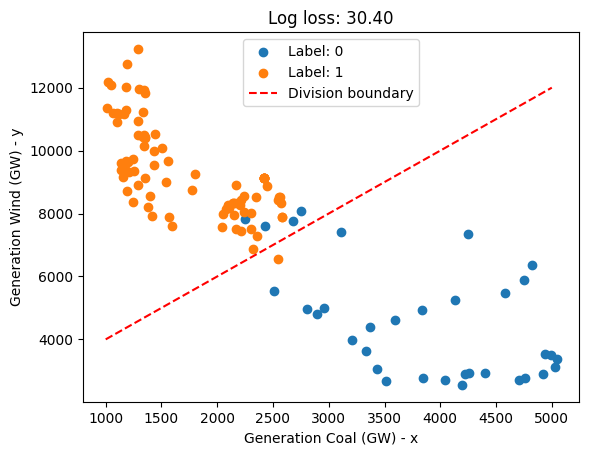

In [229]:
w = 2
b = 2000

plot_scatter(X, w=w, b=b, GoF=True)

For any new entries (e.g. the test data), we can just calculate the fitted function and its logit to estimate the class.

## Evaluation metrics in classification

As you see, with classification we are dealing with **categories** and **probabilities** instead of real values

So we can't use the same metrics to evaluate our model

*no MAE, no MSE, no RMSE, no MAPE*

Instead, we base our evaluation on a **CONFUSION MATRIX**

In [230]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

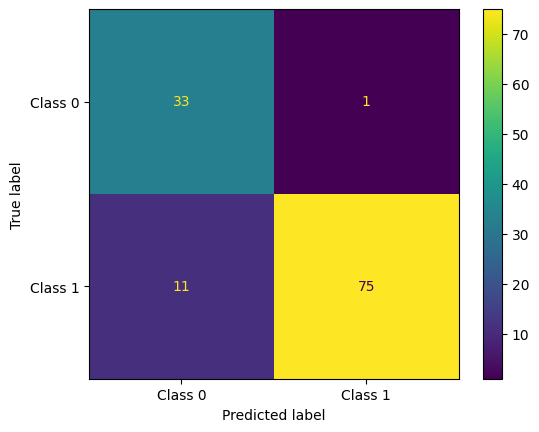

In [231]:
cm = confusion_matrix(X['label'], X['pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot()
plt.show()

**Accuracy** - percentage of correctly identified classes:

In [232]:
a = (33 + 75) / (33 + 1 + 11 + 75)

print(f'Global accuracy: {a:.2f}')

Global accuracy: 0.90


**Precision** - the cleanliness of predicted classes:

In [233]:
p_0 = 33 / (11 + 33)
p_1 = 75 / (1 + 75)

print(f'Precision: \n -Class 0: {p_0:.2f}\n -Class 1: {p_1:.2f}')

Precision: 
 -Class 0: 0.75
 -Class 1: 0.99


**Recall** - the capture rate of true class:

In [234]:
r_0 = 33 / (33 + 1)
r_1 = 75 / (11 + 75)

print(f'Recall: \n -Class 0: {r_0:.2f}\n -Class 1: {r_1:.2f}')

Recall: 
 -Class 0: 0.97
 -Class 1: 0.87


**F1 - score** - combines the precision and recall. Favors similar values of the two (not always good)

In [235]:
f1_0 = 2 * p_0 * r_0 / (p_0 + r_0)
f1_1 = 2 * p_1 * r_1 / (p_1 + r_1)

print(f'F1: \n -Class 0: {f1_0:.2f}\n -Class 1: {f1_1:.2f}')

F1: 
 -Class 0: 0.85
 -Class 1: 0.93


### Precision recall tradeoff:

The values of precision and recall depend on our model's and the selected threshold.

Unfortunately, we can't increase the **precision** and **recall** at the same time. 

The more we increse the cleanliness of our group (precision grows), the more the capture rate (recall) drops. 

We can easily visualise it on the logit plot:

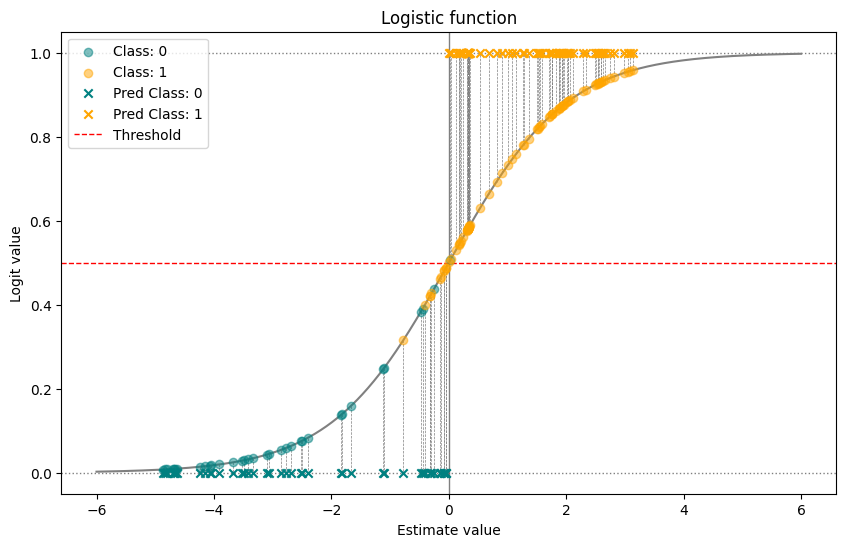

In [281]:
selected_threshold = 0.50

# PLot the logit
plot_logit(X, x_col='estimate', y_col='logit estimate', mark_classes=True, threshold=selected_threshold, figsize=(10, 6))

#plt.xlim(-0.7, 0.7)

In fact we can calculate the precision and recall for many different thresholds, and plot the dependence:

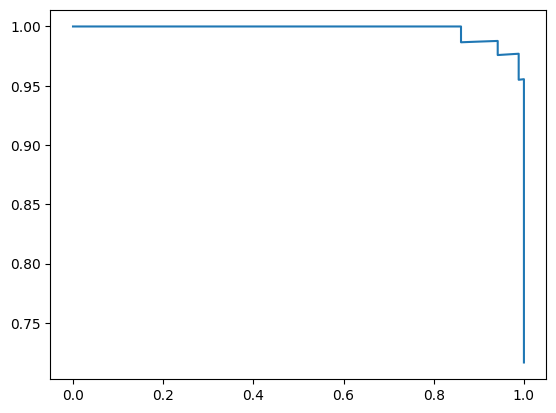

In [237]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(X['label'], X['logit estimate'])

plt.plot(recall, precision)
plt.show()

The plot shows the trade-off between the precision and recall at various thresholds and is often called the **precision-recall-curve**

It is often used to compare classifiers performance on the same dataset.

For **a perfect classifier** the curve is almost a square (as in our very simple example).

## Case study

### 1. Problem definition

*INSERT IMAGE*

The dataset that we are going to be using comes from a detailed recording of LG Li-ion batteries performed jointly by PoliMi and TUB. It is composed of discharge data of multiple battery cells at different driving cycles (LA92, US06, ect.) and various temperatures ranging from negative 25 to positive 35.

The dataset has been pubiled in open access and can be accessed [here](https://data.mendeley.com/datasets/6hyhsjbwkb/1)

In this case study we will use a small snippet of the full dataset.

**Estimate the battery State-of-Charge (high, medium, low) based on simple parameters (I, V, T)**

|I/O|  Data |
| --- | --- |
|Inputs| `I`, `V`, `T` |
|Target|  `label` (High, Medium, Low)|
|Output| `label estimate` (High, Medium, Low)|

In our dataset we have the actual SoC, however for a simple classification problem we will convert it into 3 classes - High - Medium - Low charge (for splits 100% - 75% - 25%- 0% accordingly).

*INSERT IMAGE*

### 2. Data introduction and analysis

Let's load our data and see it:

In [327]:
data_bat = pd.read_csv('data/battery_data.csv') # Replace url
data_bat

,V,I,T,Q,SoC
0,1.00,0.86,0.00,0.00,1.00
1,0.98,0.83,0.00,0.00,1.00
2,0.96,0.80,0.00,0.00,1.00
3,0.96,0.82,0.01,0.00,0.99
4,0.93,0.77,0.03,0.00,0.99
...,...,...,...,...,...
2210,0.28,0.31,0.85,0.89,0.06
2211,0.23,0.31,0.89,0.93,0.05
2212,0.22,0.40,0.91,0.91,0.03
2213,0.15,0.19,0.93,1.00,0.02


It has been already preprocessed so we do not have to worry about cleaning or scaling. 

All features range from 0 to 1.

Let's give a look at the driving cycles:

In [338]:
px.line(data_frame=data_bat, y='SoC') 

Let's add the label column based on the SoC value:

In [329]:
data_bat['label'] = ['high' if soc > 0.75 else 'low' if soc < 0.25 else 'medium' for soc in data_bat['SoC']]

Let's check out the driving cycles:

In [339]:
px.scatter(data_frame=data_bat, y='SoC', color='label') # Replace 'SoC' with 'V', 'T', or 'I' to see other features

Let's plot it in 2D a scatter plot:

In [336]:
px.scatter(data_frame=data_bat, x='T', y='SoC', color='label')

We can plot it in 3d as well:

In [337]:
fig = px.scatter_3d(data_frame=data_bat, x='V', y='I', z='T', color='label')
fig.show()

And check out the final table:

In [321]:
data_bat

,V,I,T,Q,SoC,label
0,1.00,0.86,0.00,0.00,1.00,high
1,0.98,0.83,0.00,0.00,1.00,high
2,0.96,0.80,0.00,0.00,1.00,high
3,0.96,0.82,0.01,0.00,0.99,high
4,0.93,0.77,0.03,0.00,0.99,high
...,...,...,...,...,...,...
2210,0.28,0.31,0.85,0.89,0.06,low
2211,0.23,0.31,0.89,0.93,0.05,low
2212,0.22,0.40,0.91,0.91,0.03,low
2213,0.15,0.19,0.93,1.00,0.02,low


### 3. Build and train model

There is a significant difference between our previous case study and the new one: **we have 1 more class**

The problem changes from binary to multiclass classification.

Yet our **Logistic model** supports only two classes 0 and 1.

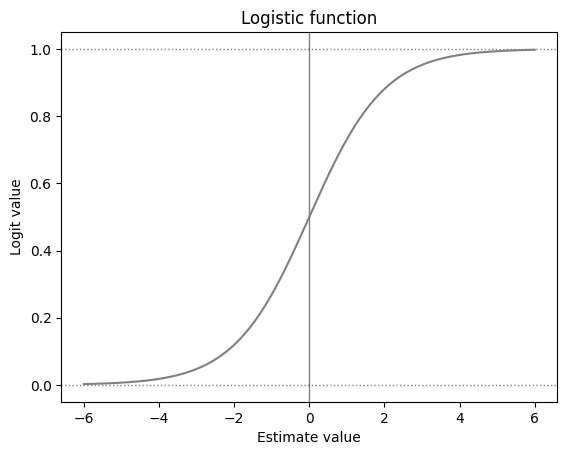

In [322]:
plot_logit()

How do we change to the multiclass case?

**ONE vs ALL classifiers**

The first answer is simple. We train multiple one vs others classifiers that are able to predict a single class.

We aggregate the results afterwards:


<img src='https://amueller.github.io/aml/_images/ovr_lines.png' width=600>

Multiclass classification

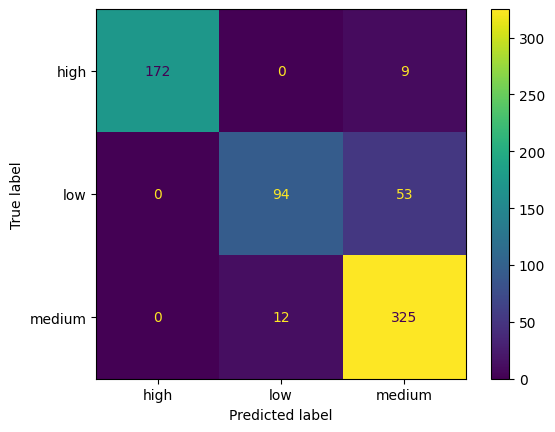

Logistic regression features: 3
Logistic regression iterations: [21 18 10]
---
Class population: 
2    337
0    181
1    147
Name: count, dtype: int64
---
Global accuracy: 0.89
---
Classes: ['high' 'low' 'medium']
Precision: [1.         0.88679245 0.83979328]
Recall: [0.95027624 0.63945578 0.96439169]
F1 score: [0.97450425 0.743083   0.89779006]


In [323]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extract data
X = data_bat[['I', 'V', 'T']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Declare the model
logr = LogisticRegression(multi_class='ovr') # OvR training
logr.fit(X_train, y_train)

# Run predictions
y_probas = logr.predict_proba(X_test)
y_preds = np.argmax(y_probas, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_pred=y_preds, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.classes_)
disp.plot()
plt.show()

# Model details
print(f'Logistic regression features: {logr.n_features_in_}')
print(f'Logistic regression iterations: {logr.n_iter_}')

# Display results
df_y = pd.DataFrame(data=y_test)
print(f'---\nClass population: \n{df_y.value_counts()}')
print(f'---\nGlobal accuracy: {accuracy_score(y_test, y_preds):.2f}')
print(f'---\nClasses: {enc.classes_}')
print(f'Precision: {precision_score(y_test, y_preds, average=None)}')
print(f'Recall: {recall_score(y_test, y_preds, average=None)}')
print(f'F1 score: {f1_score(y_test, y_preds, average=None)}')


It works fine, but only because our model is small.

What if the model is huge and we can't afford to train it multiple times?

**SOFTMAX function**

Softmax function or the Multinomial Logistic Regression is a common solution for robust classification models (e.g. big image classifiers) when we cannot afford to train the model multiple times for **OvR** predictions.

<img src='https://images.contentstack.io/v3/assets/bltac01ee6daa3a1e14/blte5e1674e3883fab3/65ef8ba4039fdd4df8335b7c/img_blog_image1_inline_(2).png?width=2048&disable=upscale&auto=webp' width=400>

Fortunately, the LogisticRegression() in sklearn supports the softmax function. We just have to change one line:

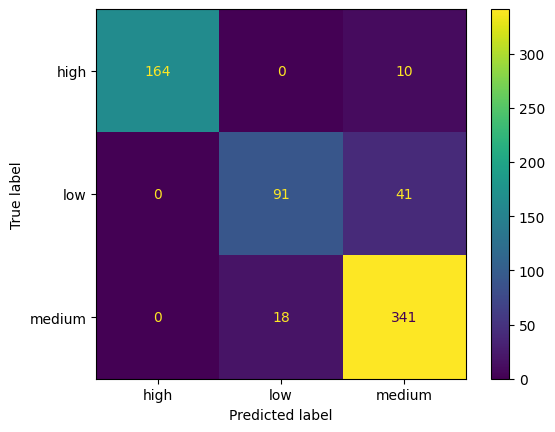

Logistic regression features: 3
Logistic regression iterations: [43]
---
Class population: 
2    359
0    174
1    132
Name: count, dtype: int64
---
Global accuracy: 0.90
---
Classes: ['high' 'low' 'medium']
Precision: [1.         0.83486239 0.86989796]
Recall: [0.94252874 0.68939394 0.94986072]
F1 score: [0.9704142  0.75518672 0.9081225 ]


In [324]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extract data
X = data_bat[['I', 'V', 'T']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Declare the model
logr = LogisticRegression(multi_class='multinomial') # we change to 'multinomial'
logr.fit(X_train, y_train)

# Run predictions
y_probas = logr.predict_proba(X_test)
y_preds = np.argmax(y_probas, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_pred=y_preds, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.classes_)
disp.plot()
plt.show()

# Model details
print(f'Logistic regression features: {logr.n_features_in_}')
print(f'Logistic regression iterations: {logr.n_iter_}')

# Display results
df_y = pd.DataFrame(data=y_test)
print(f'---\nClass population: \n{df_y.value_counts()}')
print(f'---\nGlobal accuracy: {accuracy_score(y_test, y_preds):.2f}')
print(f'---\nClasses: {enc.classes_}')
print(f'Precision: {precision_score(y_test, y_preds, average=None)}')
print(f'Recall: {recall_score(y_test, y_preds, average=None)}')
print(f'F1 score: {f1_score(y_test, y_preds, average=None)}')


The implementation details are not that important. Just remember:

$$
    \text{softmax} = \text{multiclass\ classification}
$$

In fact, typically to train a neural network classifier for multiple classes, we also use the softmax function to determine the output class:

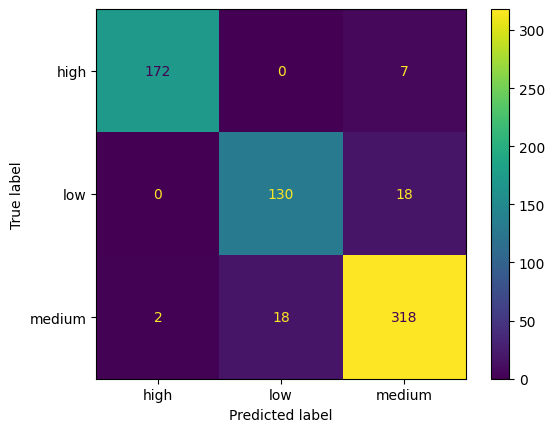

---
Class population: 
2    338
0    179
1    148
Name: count, dtype: int64
---
Global accuracy: 0.93
---
Classes: ['high' 'low' 'medium']
Precision: [0.98850575 0.87837838 0.9271137 ]
Recall: [0.96089385 0.87837838 0.9408284 ]
F1 score: [0.97450425 0.87837838 0.9339207 ]


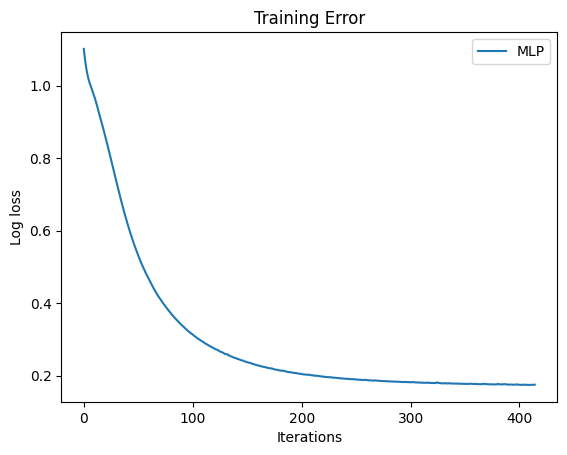

In [325]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extract data
X = data_bat[['I', 'V', 'T']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Declare the model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), solver='adam', max_iter=1000)
mlp.fit(X_train, y_train)

# Run predictions
y_probas = mlp.predict_proba(X_test)
y_preds = np.argmax(y_probas, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_pred=y_preds, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.classes_)
disp.plot()
plt.show()

# Training curve
pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='Log loss',xlabel='Iterations');

# Display results
df_y = pd.DataFrame(data=y_test)
print(f'---\nClass population: \n{df_y.value_counts()}')
print(f'---\nGlobal accuracy: {accuracy_score(y_test, y_preds):.2f}')
print(f'---\nClasses: {enc.classes_}')
print(f'Precision: {precision_score(y_test, y_preds, average=None)}')
print(f'Recall: {recall_score(y_test, y_preds, average=None)}')
print(f'F1 score: {f1_score(y_test, y_preds, average=None)}')

### 4. Advanced splitting and Cross-Validation (optional)

Despite fairly good results in our classifiers, our approach is not entirely correct. 

It is because our classes are not really balanced - numbers of members are not equal:

In [ ]:
data_bat.label.value_counts()

In fact, it has a reflection in the results as with our random data split they are not consistent.

Try to run this cell a few times and see how the results change:

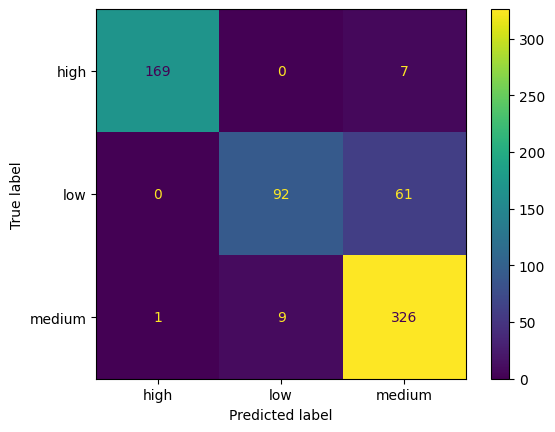

Logistic regression features: 3
Logistic regression iterations: [20 18 11]
---
Class population: 
2    336
0    176
1    153
Name: count, dtype: int64
---
Global accuracy: 0.88
---
Classes: ['high' 'low' 'medium']
Precision: [0.99411765 0.91089109 0.82741117]
Recall: [0.96022727 0.60130719 0.9702381 ]
F1 score: [0.97687861 0.72440945 0.89315068]


In [352]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extract data
X = data_bat[['I', 'V', 'T']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Declare the model
logr = LogisticRegression(multi_class='ovr') # OvR training
logr.fit(X_train, y_train)

# Run predictions
y_probas = logr.predict_proba(X_test)
y_preds = np.argmax(y_probas, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_pred=y_preds, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.classes_)
disp.plot()
plt.show()

# Model details
print(f'Logistic regression features: {logr.n_features_in_}')
print(f'Logistic regression iterations: {logr.n_iter_}')

# Display results
df_y = pd.DataFrame(data=y_test)
print(f'---\nClass population: \n{df_y.value_counts()}')
print(f'---\nGlobal accuracy: {accuracy_score(y_test, y_preds):.2f}')
print(f'---\nClasses: {enc.classes_}')
print(f'Precision: {precision_score(y_test, y_preds, average=None)}')
print(f'Recall: {recall_score(y_test, y_preds, average=None)}')
print(f'F1 score: {f1_score(y_test, y_preds, average=None)}')

The accuracies jumps around, the class populations jump around. The results are not consistent.

A good solution to that issue is the **Cross Validation**.

We divide our dataset into a K equal subgroups $(x_1, x_2, ..., x_K)$. We train the model using all the other data $(1- x_1, 1- x_2, ..., 1- x_K)$
and evaluate it on the subgroup $(x_1, x_2, ..., x_K)$. This approach is known as a **K-fold Cross Validation**

<img src='https://amueller.github.io/aml/_images/kfold_cv.png' width=600>

An even better approach in our case would split the data according to the population of the classes. In fact, we can easily do it using a ***Stratified* K-fold Cross Validation**

<img src='https://amueller.github.io/aml/_images/stratified_cv.png' width=600>

Of course this approach is computationally expensive (we have to train K models) so it is okay only for small models.

Let's train our Logistic Regression with K-fold CV:

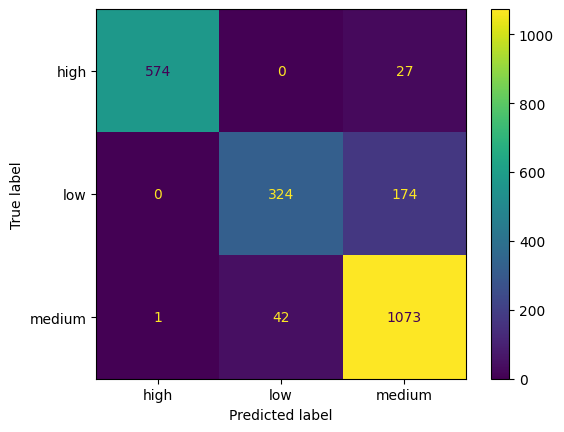

---
Class population: 
2    1116
0     601
1     498
Name: count, dtype: int64
---
Global accuracy: 0.89
---
Classes: ['high' 'low' 'medium']
Precision: [0.99826087 0.8852459  0.8422292 ]
Recall: [0.95507488 0.65060241 0.96146953]
F1 score: [0.97619048 0.75       0.89790795]


In [378]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extract data
X = data_bat[['I', 'V', 'T']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

# Data split
skf = StratifiedKFold(n_splits=5, shuffle=True) # We use Stratiifed K Fold instead of random train test split

# Declare the model
logr = LogisticRegression(multi_class='ovr') # OvR training

# Run predictions
y_preds = cross_val_predict(logr, X, y, cv=skf) # We put entire X and y, the splitter will take care of splits for us

# Plot confusion matrix
cm = confusion_matrix(y_pred=y_preds, y_true=y)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.classes_)
disp.plot()
plt.show()

# Display results
df_y = pd.DataFrame(data=y)
print(f'---\nClass population: \n{df_y.value_counts()}')
print(f'---\nGlobal accuracy: {accuracy_score(y, y_preds):.2f}')
print(f'---\nClasses: {enc.classes_}')
print(f'Precision: {precision_score(y, y_preds, average=None)}')
print(f'Recall: {recall_score(y, y_preds, average=None)}')
print(f'F1 score: {f1_score(y, y_preds, average=None)}')

Rerun this cell a few times and observe the results

The accuracy is much more stable now, and probably gives us a better idea on the performance with unseen data

### 5. Decision Tree and Random Forest classification (optional)

**Decision Trees** (and the **Random Forests**) are a bunch of very useful and extremely explainable models that excell in dealing with tabular data.

However, for decision trees it is easier to train it first and explain it later:

In [435]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Extract data
X = data_bat[['V', 'T', 'I']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Declare the model
dt = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

As the name implies the model grows a tree of binary decisions. Starting from the root node it splits the samples into two groups. 

At each node it searches for a splitting condition that minimizes the **impurity** (officially the metric is called **gini impurity**) which is equal to 1 minus the sum of squared probabilities of each class:

$$
    G_i = 1 - \sum^n_{k=1} p_{i, k}^2
$$

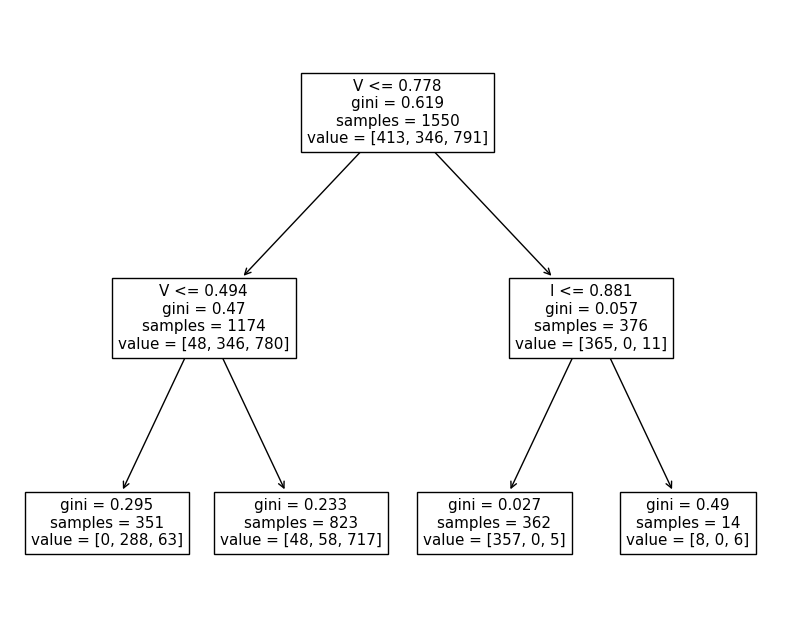

In [436]:
plt.figure(figsize=(10, 8))
plot_tree(dt, feature_names=dt.feature_names_in_)
plt.show()

The biggest issue of **DecisionTreeClassifier** is that it tends to severly overfit the data.

Indeed, if not stopped early it will continue dividing until each sample is in separate leaf. To counter we can:
* Cut the unecessary splits after training (pruning)
* Limit the maximum depth of the tree
* Limit the minimum number of samples per tree

In this way the tree does not go too deep and does not ovefit.

In [456]:
px.scatter(data_frame=data_bat, x='V', y='I', color='label')

The biggest *issue* of a decision tree is that the division boudaries are very orthogonal. It does not work with skewed, rotated or non linear data.

**Random Forest** classifier mitigates that by training numerous trees and aggregating their results together -- it picks the most common class from all the trees. 

> **Example:** we have 5 trees and feed them a test instance for prediction. The trees outpus classes labels as follows: (1, 1, 2, 1, 0). The most common prediction is 1, so the output class is 1. Democracy in the working (sort of).

Despite the simplicity of this approach is surprisingly effective and the more *independent* the trees are the better. 

To ensure *independence* we try to create different training datasets for each tree. It is done by **sampling with replacement** training instances, as shown at the image below (example for 3 trees). This approach is called *bagging*.

**INSERT IMAGE**

Notice that each *bagged* training dataset is the same size as the original one.

The training procedure is the same as usual (thanks to scikit-learn simple syntax):

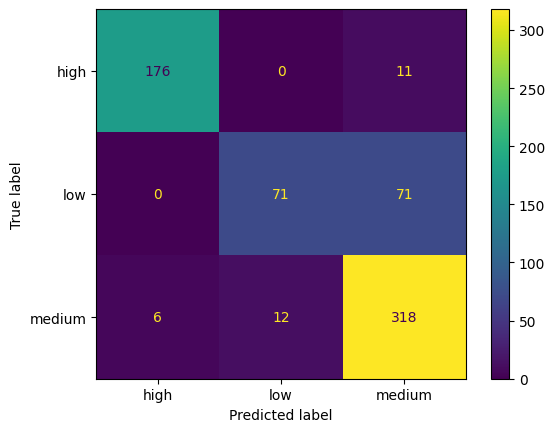

---
Class population: 
2    336
0    187
1    142
Name: count, dtype: int64
---
Global accuracy: 0.85
---
Classes: ['high' 'low' 'medium']
Precision: [0.96703297 0.85542169 0.795     ]
Recall: [0.94117647 0.5        0.94642857]
F1 score: [0.95392954 0.63111111 0.86413043]


In [502]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extract data
X = data_bat[['I', 'V', 'T']].copy()
y = data_bat['label'].copy()

# Encode our labels as 0, 1, 2 instead of text
enc = LabelEncoder()
y = enc.fit_transform(y)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Declare the model
rfc = RandomForestClassifier(n_estimators=5, criterion='gini', max_depth=3, random_state=0) # OvR training
rfc.fit(X_train, y_train)

# Run predictions
y_preds = rfc.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_pred=y_preds, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.classes_)
disp.plot()
plt.show()

# # Model details
# print(f'Logistic regression features: {logr.n_features_in_}')
# print(f'Logistic regression iterations: {logr.n_iter_}')

# Display results
df_y = pd.DataFrame(data=y_test)
print(f'---\nClass population: \n{df_y.value_counts()}')
print(f'---\nGlobal accuracy: {accuracy_score(y_test, y_preds):.2f}')
print(f'---\nClasses: {enc.classes_}')
print(f'Precision: {precision_score(y_test, y_preds, average=None)}')
print(f'Recall: {recall_score(y_test, y_preds, average=None)}')
print(f'F1 score: {f1_score(y_test, y_preds, average=None)}')

A cool thing about *Decision Trees* and *Random Forest* is that they are immune to not scaled data.

**Thank you for your attention!**